In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import os
from os.path import isfile, join, splitext
import random
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

from process_raw_prices import *


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# make sure the jupyter notebook run in this working directory
%cd ~/fyp/code/model

/home/u21376/fyp/code/model


In [3]:
tf.enable_eager_execution()

In [4]:
num_of_pair = 500

In [5]:
# processed dataset folder path
dataset_folder_path = '../../dataset/nyse-daily-transformed'
os.makedirs(dataset_folder_path, exist_ok=True)

# raw dataset files pattern
raw_files_path_pattern = "../../dataset/nyse-daily-trimmed-same-length/*.csv"

df_columns = ['close1', 'close2', 'normalizedLogClose1', 'normalizedLogClose2', 'spread', 'alpha', 'beta']
ind = {'y_close': 0, 'x_close': 1, 'spread': 4}

# compute dataset for training
all_pairs_slices = [splitext(f)[0] for f in os.listdir(dataset_folder_path) if isfile(join(dataset_folder_path, f))]
if len(all_pairs_slices) == 0:
    generate_pairs_training_data(raw_files_path_pattern=raw_files_path_pattern,
                                 result_path=dataset_folder_path,
                                 min_size=252*4,
                                 training_period=52,
                                 points_per_cut=252
                                )
    all_pairs_slices = [splitext(f)[0] for f in os.listdir(dataset_folder_path) if isfile(join(dataset_folder_path, f))]
print("Total number of pair slices: %d" % len(all_pairs_slices))

# split for training and testing
all_pairs = sorted(list(set(['-'.join(p.split('-')[0:2]) for p in all_pairs_slices])))[:num_of_pair]
# all_pairs = ["VMW-WUBA"]
# all_pairs = ["TWTR-UIS"]
all_pairs_slices_train = []
all_pairs_slices_test = []
for p in all_pairs:
    all_pairs_slices_train += [p+'-0', p+'-1']
    all_pairs_slices_test += [p+'-2', p+'-3']
print("Total number of pair slices for training: %d" % len(all_pairs_slices_train))
print("Total number of pair slices for testing: %d" % len(all_pairs_slices_test))

Total number of pair slices: 26680
Total number of pair slices for training: 1000
Total number of pair slices for testing: 1000


In [6]:
print(all_pairs)

['AAN-AER', 'AAN-AL', 'AAN-AMBR', 'AAN-AMN', 'AAN-ANET', 'AAN-ASGN', 'AAN-ATEN', 'AAN-ATHM', 'AAN-ATU', 'AAN-AUO', 'AAN-AYR', 'AAN-BHE', 'AAN-BITA', 'AAN-CACI', 'AAN-CAI', 'AAN-CLGX', 'AAN-CLS', 'AAN-CMCM', 'AAN-CRM', 'AAN-CSLT', 'AAN-CTS', 'AAN-CW', 'AAN-DATA', 'AAN-DDD', 'AAN-DOV', 'AAN-DQ', 'AAN-ECOM', 'AAN-EGHT', 'AAN-ELLI', 'AAN-EPAM', 'AAN-ETN', 'AAN-EVTC', 'AAN-FDS', 'AAN-GHM', 'AAN-GLOB', 'AAN-GWRE', 'AAN-HHS', 'AAN-HIVE', 'AAN-HPQ', 'AAN-HUBS', 'AAN-IBM', 'AAN-INFY', 'AAN-INXN', 'AAN-IPG', 'AAN-IPHI', 'AAN-ITW', 'AAN-JBL', 'AAN-JBT', 'AAN-JKS', 'AAN-JNPR', 'AAN-KAI', 'AAN-KFY', 'AAN-LDOS', 'AAN-LEAF', 'AAN-LLL', 'AAN-LXFT', 'AAN-MAN', 'AAN-MIXT', 'AAN-MODN', 'AAN-MSI', 'AAN-MX', 'AAN-MXL', 'AAN-NEWR', 'AAN-NOK', 'AAN-NOW', 'AAN-NPTN', 'AAN-NSP', 'AAN-OMC', 'AAN-ORCL', 'AAN-PANW', 'AAN-PAYC', 'AAN-PKE', 'AAN-PNR', 'AAN-PRO', 'AAN-QTM', 'AAN-QTWO', 'AAN-RENN', 'AAN-RHI', 'AAN-RHT', 'AAN-RNG', 'AAN-RST', 'AAN-RUBI', 'AAN-RXN', 'AAN-SAIC', 'AAN-SAP', 'AAN-SFUN', 'AAN-SMI', 'AAN-SN

In [7]:
# update batch size
batch_size = 128

# number of batch in training
num_of_batch = num_of_pair*500//batch_size

# fixed number of time steps in one episode (not used)
trading_period = 200

# # 1 is zscore
# num_features = 1

# 0 is no position. 1 is long the spread. 2 is short the spread.
a_num = position_num = 3

# RNN hidden state dimension
h_dim = 30

# number of RNN layer
num_layers = 2

# number of layer1 output
layer1_out_num = 30

# learning rate
lr = 5e-3

reg = 0.001

# discount factor in reinforcement learning
gamma = 1

# random action probability
rand_action_prob = 0.08

batch_per_print = 10

# dummy initial cash
initial_cash = 10000

# checkpoint folder
checkpoint_dir = '../../model_checkpoint/'
os.makedirs(checkpoint_dir, exist_ok=True)

In [8]:
# functions
def get_random_history(batch_size, training):
    """Sample some pairs and get the history of those pairs. The history should have
    three dimension. The first dimension is for time. The second dimension is indexed
    by features name. The third dimension is the index of training instance.
    """
    sample_pair_slices = random.sample(all_pairs_slices_train if training else all_pairs_slices_test, batch_size)
    history = []
    for s in sample_pair_slices:
        df = pd.read_csv(join(dataset_folder_path, s+".csv"))
        df_val = df[df_columns].values
        history.append(df_val)
    
    history = np.array(history)
    return np.transpose(history, (1, 2, 0))

def compute_input_history(history):
    """Slicing history in its second dimension."""
    # no slicing for now
    return history[:,2:]

def sample_action(logits, random=False):
    if random:
        dist = tf.distributions.Categorical(logits=tf.zeros([batch_size, a_num]))
    else:
        dist = tf.distributions.Categorical(logits=logits)
    
    # 1-D Tensor where the i-th element correspond to a sample from
    # the i-th categorical distribution
    return dist.sample()

def long_portfolio_value(q, p):
    return q*p

def short_portfolio_value(q, p, init_p):
    return q*(3.0*init_p/2 - p)

# def discount_rewards(r, all_actions):
#     """
#     r is a numpy array in the shape of (n, batch_size).
#     all_actions is a numpy array in the same shape as r.
    
#     return the discounted and cumulative rewards"""
    
#     result = np.zeros_like(r, dtype=float)
#     n = r.shape[0]
#     sum_ = np.zeros_like(r[0], dtype=float)
#     pre_action = all_actions[n-1]
#     for i in range(n-1,-1,-1):
#         sum_ *= gamma
        
#         # when the previous action(position) not equal to the current one,
#         # set the previous sum of reward to be zero.
#         sum_ = sum_*(all_actions[i]==pre_action) + r[i]
#         result[i] = sum_
        
#         # update pre_action
#         pre_action = all_actions[i]
    
#     return result

def discount_rewards(r):
    """
    r is a numpy array in the shape of (n, batch_size).
    
    return the discounted and cumulative rewards"""
    
    result = np.zeros_like(r, dtype=float)
    n = r.shape[0]
    sum_ = np.zeros_like(r[0], dtype=float)
    for i in range(n-1,-1,-1):
        sum_ *= gamma
        sum_ += r[i]
        result[i] = sum_
    
    return result

def loss(all_logits, all_actions, all_advantages):
    neg_log_select_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=all_logits, labels=all_actions)
    
    # 0 axis is the time axis. 1 axis is the batch axis
    return tf.reduce_mean(neg_log_select_prob * all_advantages, 0)

def save_model():
    hkg_time = datetime.now() + timedelta(hours=16)
    checkpoint_name = hkg_time.strftime("%Y%m%d_%H%M%S")
    checkpoint_prefix = os.path.join(checkpoint_dir, checkpoint_name)
    root.save(checkpoint_prefix)
    tf.train.latest_checkpoint(checkpoint_dir)
    
def restore_model(checkpoint_name):
    root.restore(join(checkpoint_dir, checkpoint_name))


myLeakyReLU = tf.keras.layers.LeakyReLU()
myLeakyReLU.__name__ = "myLeakyReLU"

# classes
class TradingPolicyModel(tf.keras.Model):
    def __init__(self):
        super(TradingPolicyModel, self).__init__()
        self.dense1 = tf.layers.Dense(units=layer1_out_num,
                                      activation=myLeakyReLU,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(reg)
                                     )
        self.dense2 = tf.layers.Dense(units=layer1_out_num,
                                      activation=myLeakyReLU,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(reg)
                                     )
        self.dense3 = tf.layers.Dense(units=layer1_out_num,
                                      activation=myLeakyReLU,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(reg)
                                     )
#         self.dense4 = tf.layers.Dense(units=layer1_out_num,
#                                       activation=tf.keras.layers.LeakyReLU(),
#                                       kernel_initializer=tf.contrib.layers.xavier_initializer()
#                                      )
        self.logits = tf.layers.Dense(units=a_num,
                                      activation=myLeakyReLU,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(reg)
                                     )

    def call(self, inputs):
        # Forward pass
        inputs = self.dense1(inputs)
        inputs = self.dense2(inputs)
        inputs = self.dense3(inputs)
#         inputs = self.dense4(inputs)
        logits = self.logits(inputs)
        return logits


class StateEncodingModel(tf.keras.Model):
    def __init__(self):
        super(StateEncodingModel, self).__init__()
        self.cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(h_dim) for i in range(num_layers)])
        self.state = self.cell.zero_state(batch_size, tf.float32)
    
    def call(self, inputs):
        output, self.state = self.cell(inputs, self.state)
        return output
        
    def reset_state(self):
        self.state = self.cell.zero_state(batch_size, tf.float32)


class TradingEnvironment():
    """Trading environment for reinforcement learning training.
    
    Arguments:
        state_encoding_model: the model that encode past input_history data into a state
        vector which will be fed as input to the policy network.
    """
    def __init__(self, state_encoding_model):
        # do some initialization
        self.state_encoding_model = state_encoding_model
        
        # use training dataset
        self._reset_env(training=True)
        
    def _reset_env(self, training=True):
        self.t = 0
        self.state_encoding_model.reset_state()

        # 0 is no position. 1 is long the spread. 2 is short the spread
        self.position = np.zeros(batch_size, dtype=int)
        
        # initialize the cash each agent has
        self.total_portfolio_value = np.ones(batch_size)*initial_cash
        
        # only useful when there is a postion on the spread
        self.quantity = {'x': np.zeros(batch_size), 'y': np.zeros(batch_size)}
        
        # for compute current portfolio value of the short side
        self.short_side_init_price = np.zeros(batch_size)

        # prepare a batch of history and input_history
        self.history = get_random_history(batch_size, training)
        self.input_history = compute_input_history(self.history)
        
        # create or update self.state variable
        self.update_state()
    
    def reset(self, training=True):
        """Return an initial state for the trading environment"""
        
        # determine what dataset to use
        self._reset_env(training=training)
        return self.state
    
    def compute_reward(self, action):
        """Compute the reward at time t which is the change in total portfolio value
        from time t to t+1. It also update the position for time t+1. Exit trade when
        the short side portfolio value <= 0."""
        
        r = np.zeros_like(action, dtype=float)
        cur_his = self.history[self.t]
        nex_his = self.history[self.t+1]
        
        # compute for each training instance in a batch
        for i, a in enumerate(action):
            y_p = cur_his[ind["y_close"], i]
            x_p = cur_his[ind["x_close"], i]
            nex_y_p = nex_his[ind["y_close"], i]
            nex_x_p = nex_his[ind["x_close"], i]
            
            
            if a == 0: # take no position on the spread
                # no change in portfolio value
                r[i] = 0
                self.position[i] = 0
                self.quantity['y'][i] = 0.0
                self.quantity['x'][i] = 0.0
            elif a == 1: # long the spread: long Y and short X
                # quantity of each stock will change when the current position is not previous position
                if self.position[i] == 0 or self.position[i] == 2:
                    # compute quantity from cash
                    self.quantity['y'][i] = 2.0*self.total_portfolio_value[i]/3.0/y_p
                    self.quantity['x'][i] = 2.0*self.total_portfolio_value[i]/3.0/x_p
                    self.short_side_init_price[i] = x_p

                lpv = long_portfolio_value(self.quantity['y'][i], nex_y_p)
                spv = short_portfolio_value(self.quantity['x'][i], nex_x_p, self.short_side_init_price[i])
                
                # the zero here can be changed to other positive threshold ...
                if spv <= 0:
                    # we loss all the money in the short side
                    nex_portfolio_value = lpv

                    # forced to take position 0
                    self.position[i] = 0
                else:
                    nex_portfolio_value = lpv + spv
                    self.position[i] = 1
                
                r[i] = nex_portfolio_value - self.total_portfolio_value[i]
                self.total_portfolio_value[i] = nex_portfolio_value
            elif a == 2: # short the spread: short Y and long X
                # quantity will change when the current position is not previous position
                if self.position[i] == 0 or self.position[i] == 1:
                    # compute quantity from cash
                    self.quantity['y'][i] = 2.0*self.total_portfolio_value[i]/3.0/y_p
                    self.quantity['x'][i] = 2.0*self.total_portfolio_value[i]/3.0/x_p
                    self.short_side_init_price[i] = y_p

                lpv = long_portfolio_value(self.quantity['x'][i], nex_x_p)
                spv = short_portfolio_value(self.quantity['y'][i], nex_y_p, self.short_side_init_price[i])
                
                if spv <= 0:
                    # we loss all the money in the short side
                    nex_portfolio_value = lpv

                    # forced to take position 0
                    self.position[i] = 0
                else:
                    nex_portfolio_value = lpv + spv
                    self.position[i] = 2
                
                r[i] = nex_portfolio_value - self.total_portfolio_value[i]
                self.total_portfolio_value[i] = nex_portfolio_value
        return r
    
    def update_state(self):
#         # concate next_input_history and next position to form next partial state
#         partial_state = tf.concat([self.input_history[self.t].T, tf.one_hot(self.position, position_num)], 1)
        
#         # update state
#         self.state = self.state_encoding_model(partial_state)

        observation = tf.convert_to_tensor(self.input_history[self.t].T, dtype=tf.float32)
    
        # use rnn to encode observationans and current stock state into next stock state
        stock_state = self.state_encoding_model(observation)
        
        portfolio_state = np.array([
            self.total_portfolio_value,
#             self.quantity['y'],
#             self.quantity['x']
        ]).T
        
        # stock state and portfolio state together form the whole environment state
        self.state = tf.concat([
            stock_state,
            portfolio_state,
            tf.one_hot(self.position, position_num)
        ], 1)
    
    def step(self, action):
        """Given the current state and action, return the reward, next state and done.
        This function should be called after reset.
        
        reward is of type numpy array. state is of type tensor. done is of type boolean.
        
        
        Arguments:
            action: a numpy array containing the current action for each training pair.

        Note that we follow the convention where the trajectory is indexed as s_0, a_0, r_0,
        s_1, ... . Therefore t is updated just after computing the reward is computed and
        before computing next state.
        """
        # r_t
        r = self.compute_reward(action) # also update the position for time t+1

        # t = t+1
        self.t += 1
        
        # compute s_(t+1)
        self.update_state()

        return r, self.state, (self.t+1) == trading_period

In [9]:
# create objects
pi = TradingPolicyModel()
state_encoding_model = StateEncodingModel()
env = TradingEnvironment(state_encoding_model)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# create checkpoint object
root = tf.train.Checkpoint(pi=pi, state_encoding_model=state_encoding_model, optimizer=optimizer)

In [10]:
# average_total_r = np.zeros(batch_size)
# done = False
# s = env.reset(training=True)

# with tf.GradientTape() as gt:
#     done = False
#     s = env.reset(training=True)

#     # internally the episode length is fixed by trading_period
#     while not done:
#         logits = pi(s)
#         a = sample_action(logits)
#         r, next_s, done = env.step(a.numpy())
#         average_total_r += r
# print('total_r_per_ep: {}'.format(np.mean(average_total_r)))

In [11]:
# print parameters
print('num_of_pair =', num_of_pair)
print('batch_size =', batch_size)
print('num_of_batch = {}, estimated epoch = {}'.format(num_of_batch, num_of_batch*batch_size/2/num_of_pair))
print('rand_action_prob =', rand_action_prob)
print('lr =', lr)

# for training reference only
average_total_r = np.zeros(batch_size)

start_time = time.time()
for batch in range(num_of_batch):
    
    # saving for update
    all_logits = []
    all_actions = []
    all_rewards = []
    with tf.GradientTape() as gt:
        done = False
        s = env.reset(training=True)

        # internally the episode length is fixed by trading_period
        while not done:
            logits = pi(s)
            a = sample_action(logits, random=np.random.rand() <= rand_action_prob)
            r, next_s, done = env.step(a.numpy())

            # save the episode
            all_logits.append(logits)
            all_actions.append(a)
            all_rewards.append(r)
            
            average_total_r += r
            
            # debugging
#             print(env.t)
#             print(env.t+1==200)
#             print(r[0])
#             print(env.total_portfolio_value[0])
#             print(done)
#             print(logits)

        all_logits_stack = tf.stack(all_logits)
        all_actions_stack = tf.stack(all_actions)
        all_rewards_stack = np.array(all_rewards)
        
        # compute cummulative rewards for each action
        all_cum_rewards = discount_rewards(all_rewards_stack)
        all_cum_rewards -= np.mean(all_cum_rewards)
        all_cum_rewards /= np.std(all_cum_rewards)
#         all_cum_rewards /= np.abs(all_cum_rewards).max()
        all_cum_rewards = tf.convert_to_tensor(all_cum_rewards, dtype=tf.float32)

        loss_value = loss(all_logits_stack, all_actions_stack, all_cum_rewards)
    
    grads = gt.gradient(loss_value, state_encoding_model.variables + pi.variables)
    optimizer.apply_gradients(zip(grads, state_encoding_model.variables + pi.variables))
    
    if (batch+1) % batch_per_print == 0:
        end_time = time.time()
        print("batch id: {}, average_total_r_per_ep: {:.2f}, time spent per {} batches: {:.1f}s".format(
            batch, np.mean(average_total_r/batch_per_print), batch_per_print, end_time-start_time))
        average_total_r = np.zeros(batch_size)
        start_time = time.time()
print('Finished training~')

num_of_pair = 500
batch_size = 128
num_of_batch = 1953, estimated epoch = 249.984
rand_action_prob = 0.08
lr = 0.005
batch id: 9, average_total_r_per_ep: 4.25, time spent per 10 batches: 16.6s
batch id: 19, average_total_r_per_ep: -24.66, time spent per 10 batches: 16.4s
batch id: 29, average_total_r_per_ep: 17.54, time spent per 10 batches: 16.2s
batch id: 39, average_total_r_per_ep: -6.29, time spent per 10 batches: 16.2s
batch id: 49, average_total_r_per_ep: 26.88, time spent per 10 batches: 16.0s
batch id: 59, average_total_r_per_ep: -105.42, time spent per 10 batches: 17.0s
batch id: 69, average_total_r_per_ep: -157.77, time spent per 10 batches: 17.3s
batch id: 79, average_total_r_per_ep: -162.64, time spent per 10 batches: 17.6s
batch id: 89, average_total_r_per_ep: -15.93, time spent per 10 batches: 16.1s
batch id: 99, average_total_r_per_ep: -15.12, time spent per 10 batches: 15.9s
batch id: 109, average_total_r_per_ep: 20.70, time spent per 10 batches: 16.6s
batch id: 119, av

batch id: 1029, average_total_r_per_ep: 135.31, time spent per 10 batches: 16.7s
batch id: 1039, average_total_r_per_ep: 73.97, time spent per 10 batches: 17.0s
batch id: 1049, average_total_r_per_ep: 162.85, time spent per 10 batches: 16.7s
batch id: 1059, average_total_r_per_ep: 157.87, time spent per 10 batches: 16.8s
batch id: 1069, average_total_r_per_ep: 69.44, time spent per 10 batches: 16.8s
batch id: 1079, average_total_r_per_ep: 236.68, time spent per 10 batches: 16.6s
batch id: 1089, average_total_r_per_ep: 67.42, time spent per 10 batches: 17.0s
batch id: 1099, average_total_r_per_ep: -8.56, time spent per 10 batches: 16.9s
batch id: 1109, average_total_r_per_ep: 25.31, time spent per 10 batches: 16.7s
batch id: 1119, average_total_r_per_ep: -32.08, time spent per 10 batches: 16.7s
batch id: 1129, average_total_r_per_ep: 107.94, time spent per 10 batches: 16.6s
batch id: 1139, average_total_r_per_ep: 89.03, time spent per 10 batches: 16.7s
batch id: 1149, average_total_r_pe

In [23]:
# test time
total_r = np.zeros(batch_size)

num_it = num_of_pair*2//batch_size

rs = []

for i in range(num_it):
    
    done = False
    
    # use non-training data to test
    s = env.reset(training=False)

    # internally the episode length is fixed by trading_period
    while not done:
        logits = pi(s)
        a = sample_action(logits)
        r, next_s, done = env.step(a.numpy())

    #     print(r[0])
    #     print(env.total_portfolio_value[0])
    #     print(done)

        total_r += r
    rs.append(total_r)

rs = np.array(rs).reshape(-1)
# print("At test time, average_total_r_per_ep: {:.2f}".format(np.mean(average_total_r/num_it)))

(array([ 21.,  56.,  49., 126., 161., 189., 168.,  70.,  28.,  28.]),
 array([-13138.39646521, -10680.60028082,  -8222.80409643,  -5765.00791204,
         -3307.21172765,   -849.41554326,   1608.38064113,   4066.17682552,
          6523.97300991,   8981.7691943 ,  11439.56537869]),
 <a list of 10 Patch objects>)

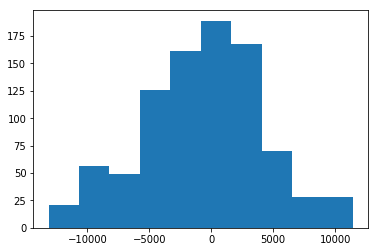

In [24]:
plt.hist(rs)